# Downloading METASPACE Annotations for Pixel Analysis

v1.0 - [Changelog](changelog.md)

This notebook will show you how to easily download datasets from METASPACE and save them as spatiomolecular matrices usable for single-pixel (i.e. single-cell-like) data analysis.

### Setup


<div class="alert alert-info">

Note

Make sure to install both [Scanpy](https://scanpy.readthedocs.io/en/stable/installation.html) and [Outer SpaceM](https://mattausc.embl-community.io/outer-spacem/installation.html) before running this notebook!

</div>

In [1]:
import pandas as pd
import outer_spacem as osm

import warnings
warnings.simplefilter("ignore")

It is highly recommended you track all datasets within a SpaceM project in a central metadata table (e.g. a csv file or an Excel sheet).
If your datasets are all part of a project on METASPACE, you can use the "Export to CSV" in the project view to get a basis for this (you might need to click "see all datasets" first).

The only requirement for your metadata table is to contain each dataset's METASPACE id.
Apart from a unique dataset ID, you can also include information such as a dataset's slide number, position on said slide, as well as biologically relevant information, e.g. treatment:

In [2]:
metadata = pd.read_csv("/Users/alberto-mac/Documents/DA_ESPORTARE/LOCAL_EMBL_FILES/scratch/projects/gastrosome_processing_full/spacem/spacem_datasets_paths_filtered.csv")
metadata.sample(3)

,datasetId,datasetName,condition,well,slide,replicate,MALDI_size,PreMaldi_res,PostMaldi_res,group,...,maldiMatrix,analyzer,resPower400,polarity,uploadDateTime,FDR@10%,database,opticalImage,metaspace_download_dir_path,path
10,2021-10-27_00h20m47s,2021-28-09_Gastrosome_Slide6Drugs_Well8_150x15...,Drugs,8,6,3,150,0.64,0.64,♡EMBL♡,...,DHB,Orbitrap,98995,positive,2021-10-26T18:20:47.944000,132,SwissLipids - 2018-02-02,https://metaspace2020.eu/fs/raw_optical_images...,/Users/alberto-mac/EMBL_ATeam/projects/gastros...,/scratch/bailoni/projects/gastrosome_processin...
8,2022-05-30_10h39m39s,2021-28-09_Gastrosome_Slide6Drugs_Well4_150x15...,Drugs,4,6,1,150,0.64,0.64,♡EMBL♡,...,DHB,Orbitrap,98995,positive,2021-10-27T00:20:59.427535,74,CoreMetabolome - v3,No optical image,/Users/alberto-mac/EMBL_ATeam/projects/gastros...,/scratch/bailoni/projects/gastrosome_processin...
7,2021-10-27_00h16m49s,2021-28-09_Gastrosome_Slide6Drugs_Well3_150x15...,Drugs,3,6,0,150,0.64,0.64,♡EMBL♡,...,DHB,Orbitrap,98995,positive,2021-10-27T00:16:49.937781,34,CoreMetabolome - v3,No optical image,/Users/alberto-mac/EMBL_ATeam/projects/gastros...,/scratch/bailoni/projects/gastrosome_processin...


In addition to your metadata table, you'll need a file pattern to save the pixel data:  
This pattern contains two wildcards encased in curly brackets: `{row}` and `{col}`. 
For each dataset tracked in your metadata table, these wildcards are going to be filled with the dataset's respective column values, i.e. the `row` and `col` columns in the metadata table.

In [3]:
pattern = "/Users/alberto-mac/EMBL_ATeam/projects/gastrosome_compare_conditions/pixel_analysis_v2/adata/pixel_matrix_{slide}_{well}.h5ad"

### Masking Cells

In single-pixel analysis we focus on pixels we consider to be overlapping with cells. For this, we select pixels that show high levels of metabolites deemed to be intracellular.  
For data covering low m/z ranges (i.e. metabolomics), nucleobases provide a decent indicator for cells, for high m/z ranges (i.e. lipidomics) consider using phospholipids.

The selection metabolites are used to compute a **rank score**, which consists of the ranks of each pixel's ion intensities, averaged across selection ions. 

\begin{equation}
S_p = \frac{\sum_{i,p} R(I_{i,p})}{n}
\end{equation}

Where $R(I_{i,p})$ is the rank of pixel $p$'s intensity $I$ for ion $i$ and $n$ is the number of detected selection metabolites's individual ions (in short: ranks are averaged across ions for each pixel). Note that this is computed separately for each dataset. 

Afterwards, the pixels are masked using a **selection threshold** corresponding to a quantile, i.e. for a threshold of 0.9 the 10% of pixels exhibiting the highest rank score are labeled as overlapping with cells.
By default, the mask will be stored in `adata.obs["am_sampling_ratio"]` for compatibility with the intracellular ion selection notebook.
A good rule of thumb for the selection threshold is to look at the **confluence** of your datasets: your threshold should be at least 1 minus the confluence, i.e. for an estimated cell confluence of 10%, set the threshold to 0.9.

In [4]:
databases = [ 
    ("SwissLipids", "2018-02-02"),
    # ("HMDB", "v4"),
    ("CoreMetabolome", "v3"),
]

# Example set for metabolomics
selection_metabolites = [
    "C42H82NO8P+H+",       # Drugs
    "C40H78NO8P+H+",      # Drugs
    "C40H78NO8P+H+",      # Drugs
    "C44H84NO8P+H+",     # Control
    "C46H82NO8P+H+",
    "C39H73O8P+Na+",
    "C46H82NO8P+Na+",
]

selection_threshold = 0.9 # Estimated confluence of 10% -> threshold = 1 - 0.1 = 0.9
fdr = 0.5

100%|████████████████████████████████████████| 221/221 [00:02<00:00, 105.04it/s]


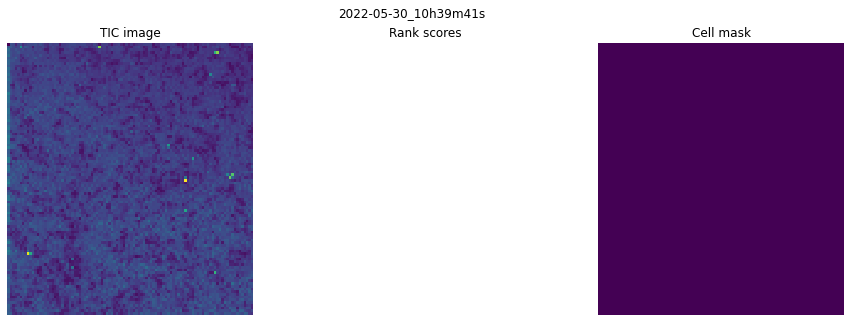

Writing pixel data to /Users/alberto-mac/EMBL_ATeam/projects/gastrosome_compare_conditions/pixel_analysis_v2/adata/pixel_matrix_1_3.h5ad


100%|████████████████████████████████████████| 297/297 [00:03<00:00, 96.58it/s] 


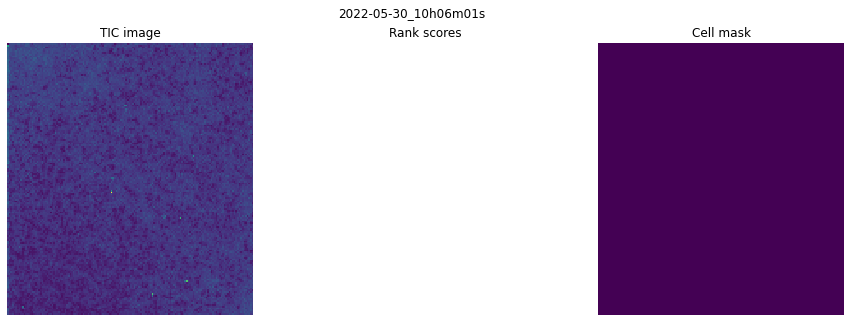

Writing pixel data to /Users/alberto-mac/EMBL_ATeam/projects/gastrosome_compare_conditions/pixel_analysis_v2/adata/pixel_matrix_1_4.h5ad


In [5]:
for idx, row in metadata.iloc[:2,:].iterrows():
    adata_path = pattern.format(**row.to_dict())

    adata = osm.io.read_metaspace_pixels(
        dataset_id=row.datasetId,
        databases=databases,
        fdr=fdr,
        selection_metabolites=selection_metabolites,
        selection_threshold=selection_threshold,
        plot_cell_mask=True
    )

    print("Writing pixel data to", adata_path)
    #adata.write(adata_path) 

\[...\]

### What's next?
This notebook allows you to download the pixel data in a format that very closely resembles the output generated by SpaceM. This means you can directly use in other notebooks in this collection, e.g. [single-cell analysis](../sc_analysis/sc_analysis.ipynb). You can even use it to [create a custom database](../intracell_selection/index.md)!

<div class="alert alert-info">

Note

While the spatiomolecular matrices have been assigned a cell mask, they have not been filtered for it yet.
If you want to conduct any analysis using only the masked pixels, you can easily filter the matrix:

```python
adata = adata[adata.obs["am_sampling_ratio"] == 1].copy()
```

</div>